In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation

from astroquery.mast import Observations
from astropy.io import fits
from ginga.util.zscale import zscale

In [2]:
paths = sorted(glob('example_csvs/*'))
targets = ['GD153', 'OMEGACEN', 'NGC-2020', 'JUPITER']

In [3]:
paths

['example_csvs/ex1ai-query_results-corrected.csv',
 'example_csvs/ex1aii-query_results.csv',
 'example_csvs/ex1aiii-query_results-5.csv',
 'example_csvs/ex2_query_results_jupiter.csv']

In [4]:
ind = 2
file = paths[ind]
target = targets[ind]

In [5]:
df = pd.read_csv(file)

In [6]:
targname = df['targname']

In [7]:
mask = targname == target

In [8]:
df_mask = df[mask]

In [12]:
obs_id = df_mask['rootname'].iloc[0]

In [13]:
obs_id

'ie6d05pzq'

In [15]:
def get_obs_from_query_criteria(df, obs_id, proposal_id=''):
    
    obs = Observations.query_criteria(obs_id=obs_id)
    df_rootname = df[df['rootname'] == obs_id]
    
    if len(obs) > 0:
        return obs
    
    elif proposal_id:
        obs = Observations.query_criteria(proposal_id=proposal_id)
        
    elif len(obs) == 0:
        try:
            proposal_id = df_rootname['proposid']
        except KeyError:
            msg = f'proposal_id not found in the dataframe. Look for Proposal ID on QL for {obs_id}.'
            raise KeyError(msg)
    
    filt = df_rootname['filter'].iloc[0]
    obs_filt = obs[obs['filters'] == filt]
    obs_id_cands = obs_filt['obs_id'].value.data
    for obs_id_cand in obs_id_cands:
        if obs_id[:6] == obs_id_cand[:6]:
            asn_id = obs_id_cand
    
    obs = obs[obs['obs_id'] == asn_id]
    
    return obs

In [21]:
obs_id = df['rootname'].iloc[33]

In [23]:
obs = get_obs_from_query_criteria(df, obs_id, proposal_id=11714)

In [24]:
obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID
str7,str3,str7,str9,str3,str17,str7,str14,str32,str40,float64,float64,str5,str15,int64,float64,float64,float64,float64,float64,str70,float64,str5,str4,int64,str415,str178,str179,str6,bool,float64,str8,str9
science,HST,CALWF3,WFC3/UVIS,HST,F555W,Optical,NGC1786,STELLAR CLUSTER;GLOBULAR CLUSTER,ib7789020,74.77052346807,-67.72777765273,image,"Bond, Howard E.",3,55182.33778834491,55182.34521886574,120.0,441.7,659.1,Snapshot Survey for Planetary Nebulae in Local Group Globular Clusters,55182.44100692,11714,SNAP,--,POLYGON 74.78627405 -67.73724016 74.76233204 -67.74378842 74.762417151110682 -67.743840182673068 74.76228583 -67.74387608 74.77805923 -67.75346441 74.80200671 -67.74691384 74.8019215136971 -67.746862106188161 74.80205278 -67.74682618 74.78627405 -67.73724016 74.78627405 -67.73724016,mast:HST/product/ib7789020_drz.jpg,mast:HST/product/ib7789020_drz.fits,PUBLIC,False,nan,24797506,138860549


In [25]:
obs_id

'ib7789tvq'

In [26]:
df.iloc[33]

id                80700
rootname      ib7789tvq
filter            F555W
expstart    55182.34375
targname        NGC1786
Name: 33, dtype: object

In [27]:
def download_raw_flt_fits(obs, obs_id):
    prods = Observations.get_product_list(obs)
    prods_filtered = Observations.filter_products(prods, obs_id=[obs_id], extension=['_raw.fits', '_flt.fits'])
    Observations.download_products(prods_filtered, mrp_only=False, cache=False)

In [28]:
download_raw_flt_fits(obs, obs_id)

In [33]:
def get_raw_flt_data(obs_id):
    
    paths_fits = sorted(glob(f'mastDownload/HST/{obs_id}/*'))
    file_flt, file_raw = paths_fits
    
    data_raw = fits.getdata(file_raw, 'SCI', 1)
    data_sci = fits.getdata(file_flt, 'SCI', 1)
    data_err = fits.getdata(file_flt, 'ERR', 1)
    data_dq = fits.getdata(file_flt, 'DQ', 1)
    
    detector = fits.getval(file_flt, 'detector')
    subarray = fits.getval(file_flt, 'subarray')
    
    if detector == 'UVIS' and subarray == False:
        data_raw2 = fits.getdata(file_raw, 'SCI', 2)
        data_sci2 = fits.getdata(file_flt, 'SCI', 2)
        data_err2 = fits.getdata(file_flt, 'ERR', 2)
        data_dq2 = fits.getdata(file_flt, 'DQ', 2)
        
        data_raw = np.vstack((data_raw, data_raw2))
        data_sci = np.vstack((data_sci, data_sci2))
        data_err = np.vstack((data_err, data_err2))
        data_dq = np.vstack((data_dq, data_dq2))

    data = [data_raw, data_sci, data_err, data_dq]

    return data

In [34]:
data = get_raw_flt_data(obs_id)

In [35]:
data_sci = data[1]

In [37]:
def plot_images(obs_id, data, dq_flag):
    
    subplot_titles = ['RAW (DN)', 'FLT SCI (e-)', 'FLT ERR (e-)', 'FLT DQ']
    
    for i in range (3):
        vmin, vmax = zscale(data[i])
        plt.title(f'{obs_id} {subplot_titles[i]}')
        plt.imshow(data[i], vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
        plt.colorbar()
        plt.show()
        
    data_dq_one_flag = np.bitwise_and(data[3], dq_flag)
    plt.figure(figsize=[5,5])
    plt.title(f'{obs_id} {subplot_titles[3]}: Flag == {dq_flag}')
    plt.imshow(data_dq_one_flag, origin='lower', cmap='gray')
    plt.tick_params()
    plt.show()

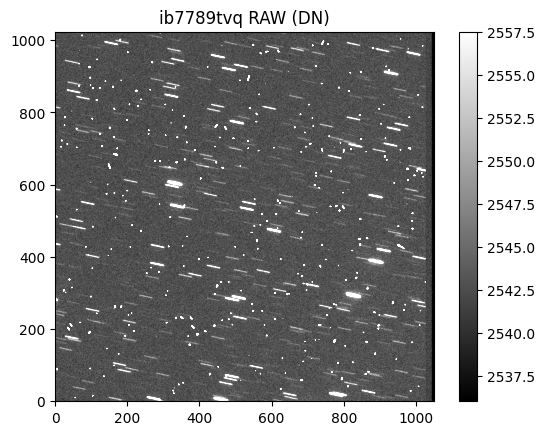

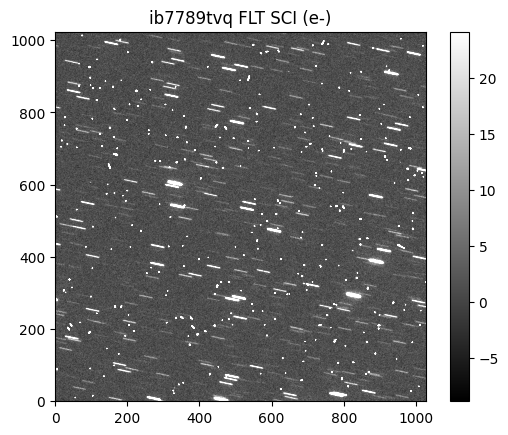

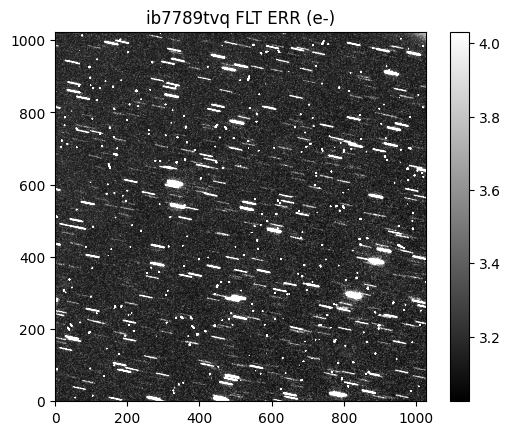

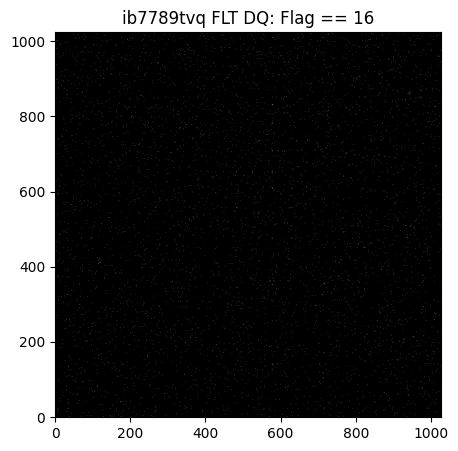

In [38]:
plot_images(obs_id, data, 16)

In [39]:
def plot_histograms(obs_id, data_sci):
    
    fontsize = 15
    fig, axs = plt.subplots(1,2,figsize=[15,5])

    axs[0].set_title(f'{obs_id} Histogram', fontsize=fontsize)
    axs[0].hist(data_sci.flatten(), bins=100)
    axs[0].set_xlabel('e-', fontsize=fontsize)
    axs[0].set_ylabel('Frequency', fontsize=fontsize)
    axs[0].set_yscale('log')
    axs[0].tick_params(labelsize=fontsize)

    data_log = np.log10(data_sci[data_sci>0].flatten())
    axs[1].set_title(f'{obs_id} Histogram (Data > 0; Log scale)', fontsize=fontsize)
    axs[1].hist(data_log, bins=100)
    axs[1].set_xlabel('log(e-)', fontsize=fontsize)
    axs[1].set_ylabel('Frequency', fontsize=fontsize)
    axs[1].set_yscale('log')
    axs[1].tick_params(labelsize=fontsize)

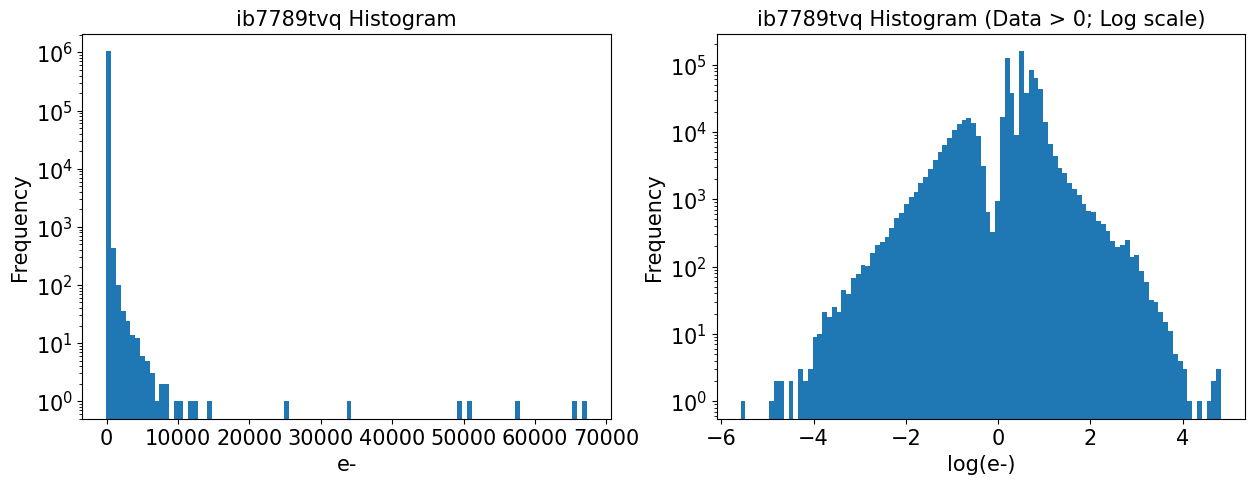

In [40]:
plot_histograms(obs_id, data_sci)

In [41]:
def plot_sci_lt_0(obs_id, data_sci):
    data_sci_lt_0 = data_sci <= 0
    fig, axs = plt.subplots(1,2,figsize=[10,5])

    axs[0].set_title(f'{obs_id} FLT SCI:\n <= 0')
    axs[0].imshow(data_sci_lt_0, origin='lower')

    axs[1].set_title(f'{obs_id} FLT SCI:\n <= 0 (subsection)')
    axs[1].imshow(data_sci_lt_0[100:200, 100:200], origin='lower')
    
    percent = 100 * data_sci_lt_0.sum() / (data_sci.shape[0] * data_sci.shape[1])
    print (f'{percent:.3f}% of pixels are less than 0')

In [48]:
array = np.ones(10).astype(bool)
array2 = np.ones(10).astype(bool)

In [49]:
array[::2] = 0

In [57]:
~array

array([ True, False,  True, False,  True, False,  True, False,  True,
       False])

In [53]:
mask1 = df['filter'] == 'F814W'
mask2 = df['expstart'] < 55594
mask = mask1 & mask2

In [54]:
df[mask]

,id,rootname,filter,expstart,targname
0,63222,ib5s05kkq,F814W,55593.25781,IC348
1,63223,ib5s05kmq,F814W,55593.26172,IC348
2,63224,ib5s05kpq,F814W,55593.26953,IC348
3,63226,ib5s05ktq,F814W,55593.27344,IC348
4,63227,ib5s05kvq,F814W,55593.27734,IC348
5,63228,ib5s05kyq,F814W,55593.28125,IC348
6,63229,ib5s05kzq,F814W,55593.28516,IC348
7,63230,ib5s05l0q,F814W,55593.29297,IC348
8,63231,ib5s05l2q,F814W,55593.32422,IC348
9,63233,ib5s05l5q,F814W,55593.32813,IC348


30.648% of pixels are less than 0


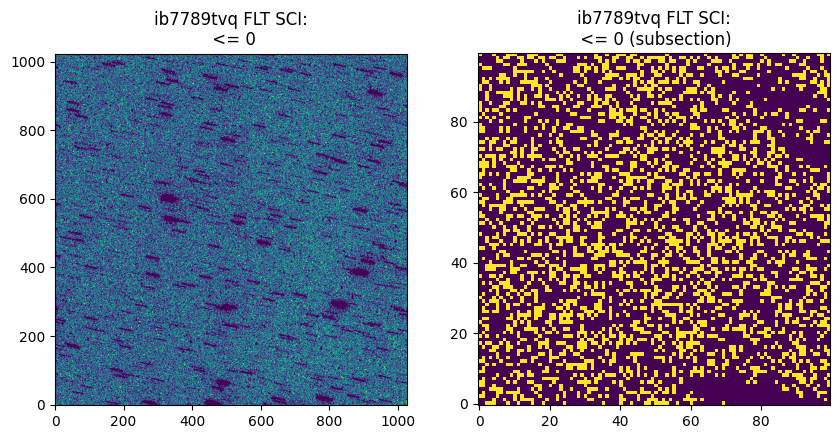

In [42]:
plot_sci_lt_0(obs_id, data_sci)

In [58]:
def get_stats(data_sci):
    
    data_sci_mean = np.mean(data_sci)
    data_sci_median = np.median(data_sci)
    data_sci_min = np.min(data_sci)
    data_sci_max = np.max(data_sci)
    data_sci_std = np.std(data_sci)
    data_sci_mad = median_abs_deviation(data_sci.flatten())

    data_sci_stats = [data_sci_mean, data_sci_median, 
                      data_sci_min, data_sci_max, 
                      data_sci_std, data_sci_mad]
    
    return data_sci_stats

In [59]:
data_sci_stats = get_stats(data_sci)

In [60]:
data_sci_stats

[3.930008, 1.6215727, -22.068235, 67264.9, 144.78294, 2.7739017009735107]